In [38]:
import numpy as np
import cv2
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Obtención de la matriz a través de una imagen

In [39]:
import cv2
import numpy as np

def img2mat(image_path, n_colors):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Remove the black points
    # Convert image to RGBA if not already
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    # Create a mask where black pixels are detected
    black_mask = (image[:, :, 0] <= 0) & (image[:, :, 1] <= 0) & (image[:, :, 2] <= 0)

    # Set alpha channel (transparency) to 0 where the mask is true (black pixels)
    image[black_mask, 3] = 0
    step_i = image.shape[0]//n_colors
    step_j = image.shape[1]//n_colors

    # Select the middle point of the square
    new_image = np.zeros((n_colors,n_colors,4))
    for i in range(n_colors):
        for j in range(n_colors):
            new_image[i,j,:] = image[image.shape[0]//n_colors//2+step_i*i,image.shape[1]//n_colors//2+step_j*j,:]

    flat_pixels = new_image.reshape(-1, 4)
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(flat_pixels)
    pixel_labels = kmeans.labels_

    # Reshape back to image dimensions
    final_matrix = pixel_labels.reshape(n_colors, n_colors) +1
    return final_matrix, ListedColormap(kmeans.cluster_centers_/255)


In [40]:
image_path = "Data/queens2.png"   # <-- Change to your file
n_colors = 10                     # Number of distinct colors to segment
matrix, colors = img2mat(image_path, n_colors)
matrix

array([[ 5,  5,  5,  5,  1,  7,  7,  7,  7,  7],
       [ 3, 10,  8,  8,  1,  4,  7,  6,  6,  6],
       [ 3, 10,  8,  8,  1,  4,  7,  7,  4,  6],
       [ 3, 10,  8,  8,  1,  4,  4,  4,  4,  6],
       [ 3,  3,  8,  8,  1,  3,  6,  6,  4,  6],
       [ 3,  3,  8,  8,  1,  3,  2,  6,  6,  6],
       [ 3,  3,  8,  8,  3,  3,  2,  2,  6,  2],
       [ 3,  3,  3,  3,  3,  2,  2,  2,  6,  2],
       [ 9,  9,  9,  3,  3,  2,  2,  2,  6,  2],
       [ 9,  9,  9,  3,  3,  2,  2,  2,  2,  2]])

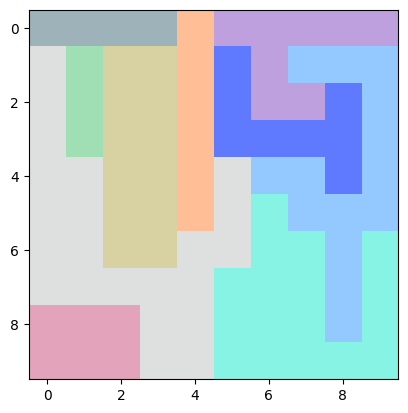

In [42]:
plt.imshow(matrix, cmap=colors)
plt.show()

# Solver

In [14]:
import pyomo.environ as pyo

def queens_solver(matrix):
    
    n,m = matrix.shape

    model = pyo.ConcreteModel()
    model.name = "Queens_Solver"

    # Sets 
    model.I = pyo.RangeSet(1, n)
    model.J = pyo.RangeSet(1, m)
    # model.colors = pyo.Set(initialize=sorted(set(np.unique(matrix))))
    model.colors = pyo.RangeSet(1,n)

    indices_matrix = {}
    for c in range(1,n+1):
        indices_matrix[c] = []
        for i in range(n):
            for j in range(m):
                if matrix[i,j] == c:
                    indices_matrix[c].append((i,j))
    
    # Variables (square of the quadrant)
    model.x = pyo.Var(model.I, model.J, domain=pyo.Binary)

    # Constraints
    # Each row has to contain only 1 crown
    def row_constraint(model, i):
        return sum(model.x[i,j] for j in model.J) == 1
    model.row_constraint = pyo.Constraint(model.I, rule = row_constraint)

    # Each column has to contain only 1 crown
    def column_constraint(model, j):
        return sum(model.x[i,j] for i in model.I) == 1
    model.column_constraint = pyo.Constraint(model.J, rule = column_constraint)

    # Adjacent cell constraints (including diagonals)
    def adjacent_constraint(model, i, j):
        # Only top diagonals neighbors
        # diagonals = [(i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        diagonals = [(i-1, j-1), (i-1, j+1)]
        neighbors = [(ii, jj) for (ii, jj) in diagonals
                    if 1 <= ii <= n and 1 <= jj <= m]
        return model.x[i, j] + sum(model.x[ii, jj] for (ii, jj) in neighbors) <= 1
    model.adjacent_constraint = pyo.Constraint(model.I, model.J, rule=adjacent_constraint)

    # # Color assignment constraints
    def color_constraint(model, c):
        suma = sum(model.x[i+1, j+1] for i,j in indices_matrix[c]) 
        return suma <= 1
    model.color_constraint = pyo.Constraint(model.colors, rule=color_constraint)

    # Objective (Optional - if needed for optimal arrangement)
    model.obj = pyo.Objective(expr=0, sense=pyo.maximize)

    solver = pyo.SolverFactory('gurobi')
    result = solver.solve(model, tee=False)  # tee=True prints solver log to screen
    # print("Solver status:", result.solver.status)
    # print("Termination condition:", result.solver.termination_condition)
    solution = np.zeros_like(matrix)
    for i in range(1, n+1):
        for j in range(1, m+1):
            if pyo.value(model.x[i, j]) == 1:
                solution[i-1, j-1] = 1

    return solution, model

In [43]:
np.unique(matrix)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [44]:
solution, model = queens_solver(matrix)
print(solution)

[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


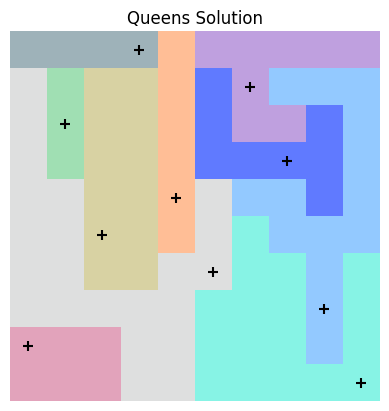

In [47]:
plt.imshow(matrix, cmap=colors)
y, x = np.where(solution == 1)
# Add points for `solution == 1` positions
plt.scatter(x, y, color='black', marker='+', s=50, label='Solution Points')
plt.axis("off")
plt.title("Queens Solution")
plt.show()

# Usando los scripts

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from image_matrix import img2mat
from queens_solver import queens_solver

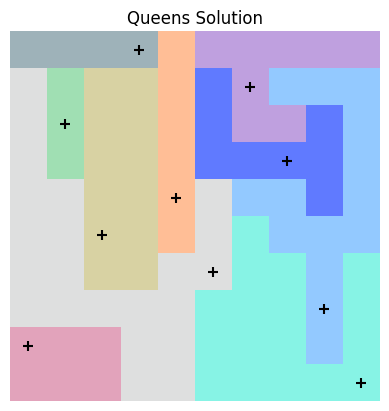

In [4]:
image_path = "Data/queens2.png"   
n_colors = 10                     # Number of distinct colors to segment
matrix, colors = img2mat(image_path, n_colors)
solution, model = queens_solver(matrix)

# Plot the solution
plt.imshow(matrix, cmap=colors)
y, x = np.where(solution == 1)
plt.scatter(x, y, color='black', marker='+', s=50, label='Solution Points')
plt.axis("off")
plt.title("Queens Solution")
plt.show()